# Import

In [16]:
%load_ext autoreload
%autoreload 2

import time
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt
import sys
# Import the Network class
from pyhgf.model import Network
from pyhgf import load_data
from pyhgf.utils import sample_node_distribution,scan_sampling, handle_observation,inference_prediction
seed = int(time.time())
rng_key = random.PRNGKey(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Predictive Agent
## 
In this notebook, we first create two agents: one with a binary child node (where the inputs are observed) and one with a continuous child node.
Rather than merely observing data, we want our agents to think and simulate the future by sampling from their own distributions and then inserting the samples as observations.

## Sampling the child nodes

### Continuous Agent
We create an agent with two nodes, including a child continuous node as the input.

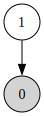

In [17]:
# Define an agent with a continuous node and display the network
agent_1 = (
    Network()  # Create a new network
    .add_nodes(precision=1e1)  # Add Node 1: Continuous node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)

# Plot the network structure
agent_1.plot_network()

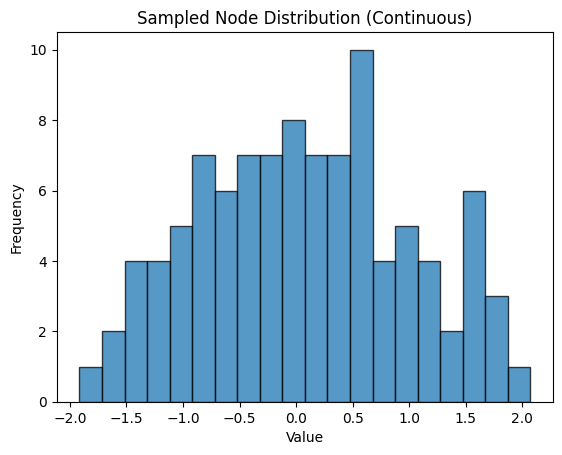

In [18]:
# Run the scan to generate multiple samples
num_samples = 100  # Number of samples to generate
samples = scan_sampling(
    agent_1.attributes,        # Network attributes
    0,                         # Node index to sample from
    rng_key,                   # Random number generator key
    agent_1.edges[0].node_type, # Node type for the specified node
    num_samples                # Number of samples to generate
)

# Plot the sampled distribution
plt.hist(samples, bins=20, alpha=0.75, edgecolor='k')  # Histogram of samples
plt.title("Sampled Node Distribution (Continuous)")    # Title of the plot
plt.xlabel("Value")                                     # X-axis label
plt.ylabel("Frequency")                                 # Y-axis label
plt.show()                                              # Display the plot

array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

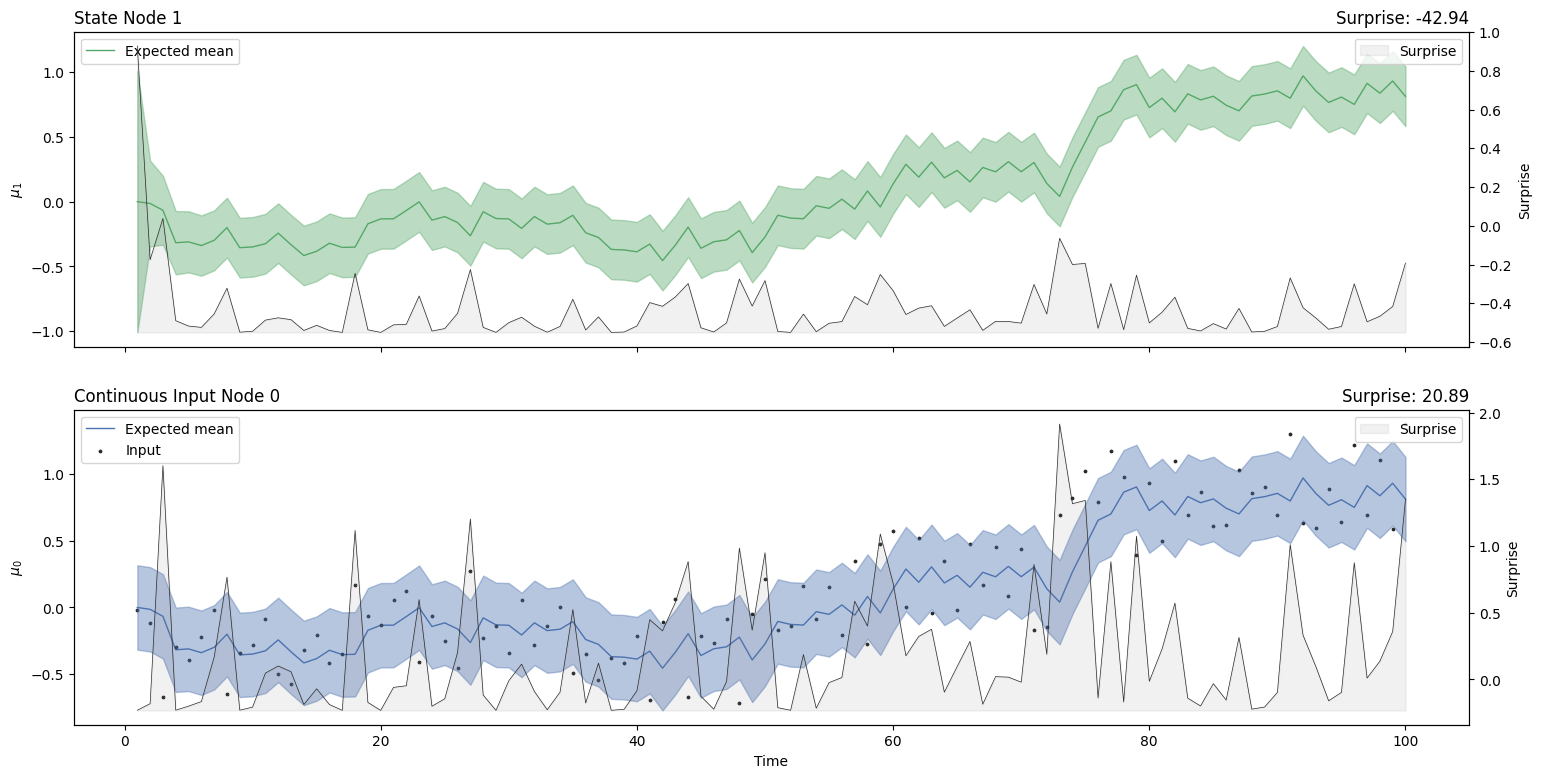

In [19]:
rng_key, subkey = random.split(rng_key)
# Generate predictions based on the agent's internal model and inputs
agent_1.input_data_prediction(time_steps=np.ones(100),rng_key=rng_key)
# Plot the predicted trajectories to visualize the agent's future states
agent_1.plot_trajectories()

### Binary agent

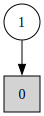

In [20]:
# Define an agent with a binary node and display the network
agent_2 = (
    Network()  # Create a new network
    .add_nodes(kind="binary-state", precision=1e2)  # Add Node 1: Binary state node with a specified precision
    .add_nodes(value_children=[0])  # Add Node 2: Child node linked to Node 1
)

# Plot the network structure
agent_2.plot_network()

In [21]:
# Sample from the binary node
sample = sample_node_distribution(
    agent_2.attributes,        # Attributes of the network
    0,                         # Node index to sample from (Node 1)
    rng_key,                   # Random number generator key
    agent_2.edges[0].node_type # Node type for the specified node
)

# Print the sampled value along with the node's mean and precision
mean = agent_2.attributes[0]['expected_mean']
precision = agent_2.attributes[0]['expected_precision']
print(f"Sampled node with mean of {mean} and a precision of {precision}: {sample}")

Sampled node with mean of 0.5 and a precision of 1.0: (Array(1., dtype=float32), Array([1670898175, 3866271898], dtype=uint32))


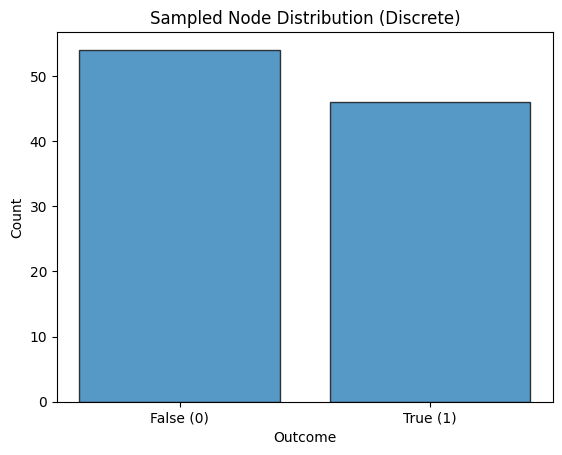

In [22]:
samples = scan_sampling(agent_2.attributes, 0, rng_key, agent_2.edges[0].node_type, num_samples)

# Plot the results
true_count = jnp.sum(samples)
false_count = num_samples - true_count
plt.bar(["False (0)", "True (1)"], [false_count, true_count], alpha=0.75, edgecolor='k')
plt.title("Sampled Node Distribution (Discrete)")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.show()

array([<Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Binary Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

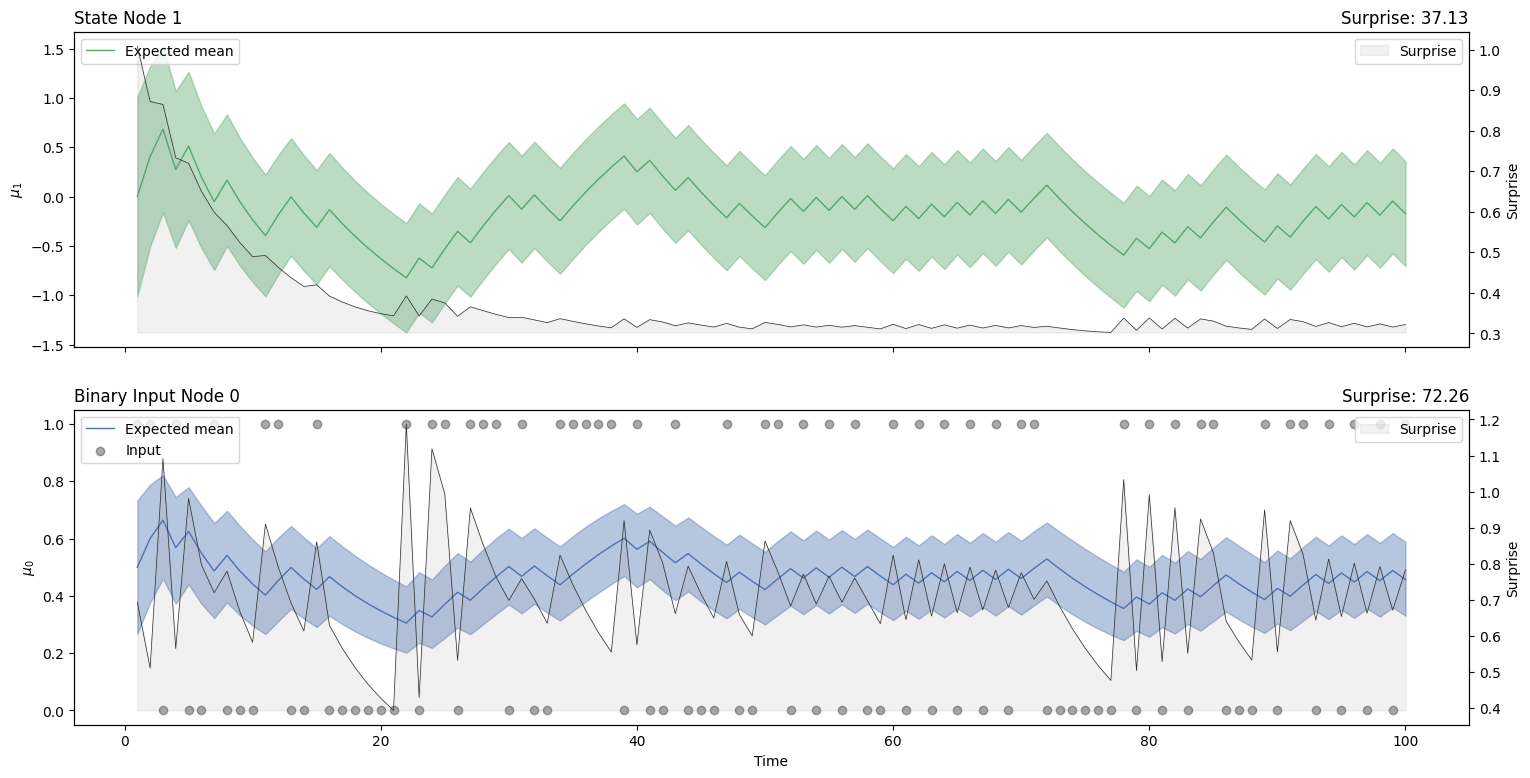

In [23]:
rng_key, subkey = random.split(rng_key)
# Generate predictions based on the agent's internal model and inputs
agent_2.input_data_prediction(rng_key=rng_key)
# Plot the predicted trajectories to visualize the agent's future states
agent_2.plot_trajectories()